## Installing and Importing Packages

In this section, we will install and import the packages that we will utilize throughout the notebook.

**RESTART session after `hazm` installation**

In [37]:
!pip install -qU hazm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 35.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 22.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [1]:
!git clone https://github.com/aryazady/lstm_crf.git
!pip install -e /content/lstm_crf/. -q
!pip install -q transformers[torch]

Cloning into 'lstm_crf'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 74 (delta 33), reused 32 (delta 7), pack-reused 0
Receiving objects: 100% (74/74), 21.38 KiB | 7.13 MiB/s, done.
Resolving deltas: 100% (33/33), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.1 MB/s eta 0:00:00


In [34]:
import json
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import torch
import hazm
from hazm import word_tokenize
from numpy.random import randint
import tensorflow as tf
import pickle
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoConfig, Trainer, TrainingArguments, TFAutoModelForTokenClassification, AutoModelForTokenClassification
import copy

import sys
sys.path.insert(0, '/content/lstm_crf/')

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

from bi_lstm_crf.app import WordsTagger

normalizer = hazm.Normalizer()

## Creating Dataset (train, test, validation)

As mentioned, we are utilizing the ARMAN dataset for token NER tagging. Here, we create our training, testing, and validation datasets from files downloaded earlier. The final structure for the dataset is a dictionary of [sentence, tag], where sentences are lists of tokens, and each sentence has a corresponding tag for its tokens.

In [86]:
base = '/content/drive/MyDrive/CurrentData'

train_data = {'sentence': [], 'tag': []}
val_data = {'sentence': [], 'tag': []}
test_data = {'sentence': [], 'tag': []}

with open(os.path.join(base, 'train.txt'), 'r') as f:
  lines = f.readlines()
  tokens = []
  bio_tags = []
  for line in lines:
    if len(line.strip()) == 0:
      train_data['sentence'].append(tokens[:])
      train_data['tag'].append(bio_tags[:])
      tokens.clear()
      bio_tags.clear()
      continue
    token, bio = line.strip().split()
    tokens += [token]
    bio_tags += [bio]


with open(os.path.join(base, 'dev.txt'), 'r') as f:
  lines = f.readlines()
  tokens = []
  bio_tags = []
  for line in lines:
    if len(line.strip()) == 0:
      val_data['sentence'].append(tokens[:])
      val_data['tag'].append(bio_tags[:])
      tokens.clear()
      bio_tags.clear()
      continue
    token, bio = line.strip().split()
    tokens += [token]
    bio_tags += [bio]

with open(os.path.join(base, 'test.txt'), 'r') as f:
  lines = f.readlines()
  tokens = []
  bio_tags = []

  for line in lines:
    if len(line.strip()) == 0:
      test_data['sentence'].append(tokens[:])
      test_data['tag'].append(bio_tags[:])
      tokens.clear()
      bio_tags.clear()
      continue

    token, bio = line.strip().split()

    tokens += [token]
    bio_tags += [bio]

### Creating Files Compatible with our Model

For NER tagging using LSTM/CRF, we will use a pre-written code available on [GitHub](https://github.com/jidasheng/bi-lstm-crf). To ensure compatibility with this code, we need to create three files:
*  dataset.txt: The entire dataset is structured as follows: [sentence \t tag \n].
*  tags.json: List of unique tags
*  and vocab.json: List of unique words

In [87]:
!mkdir corpus
with open("/content/corpus/dataset.txt", "w") as f:
  for idx, sentence in enumerate(train_data['sentence']):
    s = json.dumps(sentence)
    tag = json.dumps(train_data['tag'][idx])
    f.writelines([s, '\t', tag, '\n'])
  for idx, sentence in enumerate(val_data['sentence']):
    s = json.dumps(sentence)
    tag = json.dumps(val_data['tag'][idx])
    f.writelines([s, '\t', tag, '\n'])

classes = []
for tags in train_data['tag']:
  classes += tags
unique_classes = set(classes)
unique_classes = list(unique_classes)
unique_classes.sort()
json_string = json.dumps(unique_classes)
with open("/content/corpus/tags.json", "w") as f:
    f.write(json_string)

word_to_ix = {}
for sentence in train_data['sentence']:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
for sentence in val_data['sentence']:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

for sentence in test_data['sentence']:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

vocab = list(word_to_ix.keys())
json_string = json.dumps(vocab)
with open("/content/corpus/vocab.json", "w") as f:
    f.write(json_string)

# Bi-LSTM/CRf

## Training BiLSTM/CRF Model

Here, we will utilize the previously installed bi_lstm_crf package to train and validate our model.

**BiLSTM/CRF Model**

in this package we:
* model.py
* crf.py
* train.py
* predict.py
* utility scripts

`model.py`: In this script, we will initialize our LSTM and CRF models. The input it takes includes:
* vocab_size: the number of unique words
* tagset_size: the number of unique tags
* embedding_dim: the size of word embeddings
* hidden_dim: the size of the hidden layer
* num_rnn_layers: the number of RNN layers
* rnn: the choice of RNN architecture, either LSTM or GRU.

With these parameters, it will instantiate the RNN and CRF models.

This script also includes three functions:
* __build_features: This function utilizes word IDs in the sentence and returns embeddings for each word in the sentence.
* loss: This function is used during the training phase. The loss is calculated through the CRF model loss.
* forward: This function is used for predicting tags given a sentence.

`crf.py`: In this script, we will take word embeddings and number of unique tags. it will predict tags for each token using a linear transformation from word embedding to tags.

This script also includes five functions:
* __score_sentence: Using word embeddings and tags, it calculates the score of provided tags. For scoring, it uses a transition matrix (nn.Parameters).
* __viterbi_decode: Using the Viterbi algorithm, it decodes word embeddings to find the highest scoring tags.
* __forward_algorithm: Using the forward algorithm, it calculates the *partition function* and returns the score for the sentence using the transition matrix.
* loss: This function is used during the training phase. The loss is calculated through __score_sentence and __forward_algorithm
* forwad: This function is used for predicting tags given a sentence using __viterbi_decode.

`train.py`: In this script, we will construct our model. Additionally, using the given parameters, we will split the dataset into train, test, and validation sets, and instantiate the Adam optimizer. Over the given epochs, we will proceed to train and evaluate our model. Furthermore, we will save the losses and the parameters of the best-performing model.

`predict.py`: In this script, we will predict NER tags for given senetences.

In [ ]:
!python -m bi_lstm_crf '/content/corpus' --model_dir "/content/drive/MyDrive/CurrentData/lstm_crf_model_5" --num_epoch 100 --batch_size 512 --val_split 0.1 --test_split 0.001 --save_best_val_model

config /content/corpus/vocab.json loaded
config /content/corpus/tags.json loaded
tag dict file => /content/drive/MyDrive/CurrentData/lstm_crf_model_5/tags.json
tag dict file => /content/drive/MyDrive/CurrentData/lstm_crf_model_5/vocab.json
parsing /content/corpus/dataset.txt: 15362it [00:00, 31199.86it/s]
dataset cache((15362, 100), (15362, 100)) => /content/corpus/dataset_cache_100.npz
datasets loaded:
	train: torch.Size([13811, 100]), torch.Size([13811, 100])
	val: torch.Size([1536, 100]), torch.Size([1536, 100])
	test: torch.Size([15, 100]), torch.Size([15, 100])
 1/100 loss: 17.83, val_loss:  0.00: 100% 27/27 [00:07<00:00,  3.56it/s]
eval: 100% 3/3 [00:00<00:00, 22.57it/s]
 2/100 loss: 15.31, val_loss: 20.77: 100% 27/27 [00:05<00:00,  5.36it/s]
eval: 100% 3/3 [00:00<00:00, 16.86it/s]
 3/100 loss: 14.24, val_loss: 17.53: 100% 27/27 [00:05<00:00,  5.19it/s]
eval: 100% 3/3 [00:00<00:00, 21.03it/s]
 4/100 loss: 13.20, val_loss: 15.66: 100% 27/27 [00:04<00:00,  5.69it/s]
eval: 100% 3/3 

## Visualizing Loss

Using the saved losses from the training phase, we plot the training loss against the validation loss.

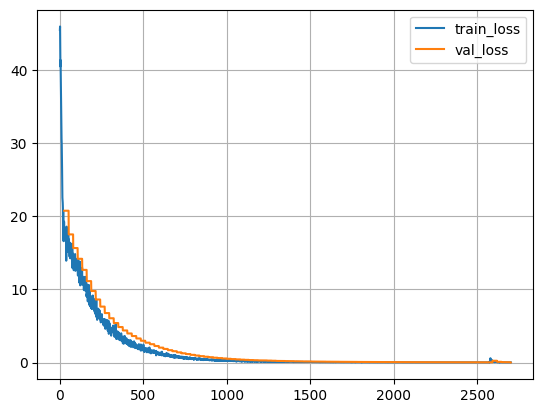

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CurrentData/lstm_crf_model_5/loss.csv")
df[["train_loss", "val_loss"]].ffill().plot(grid=True)
plt.show()

## Evaluation on Test Dataset

Here we use our best model to predict NER tags on test dataset and evaluate model for overfitting. For this purpose we will use `WordsTagger`, that it takes model directory as input. 

In [90]:
model = WordsTagger(model_dir="/content/drive/MyDrive/CurrentData/lstm_crf_model_5")
tags, sequences = model(test_data['sentence'])

In [91]:
y_true = []
y_pred = []
for tgs in test_data['tag']:
  for t in tgs:
    y_true.append(t)
for tgs in tags:
  for t in tgs:
    y_pred.append(t)

Calculating `Accuracy`, `Precision`, `Recall` and `F1-score` metrics for test dataset. Also plotting it's `Confusion Matrix`.

Accuracy: 0.9994
Precision macro: 0.9973
Precision micro: 0.9994
Recall macro: 0.9903
Recall micro: 0.9994
F1 macro: 0.9936
F1 micro: 0.9994


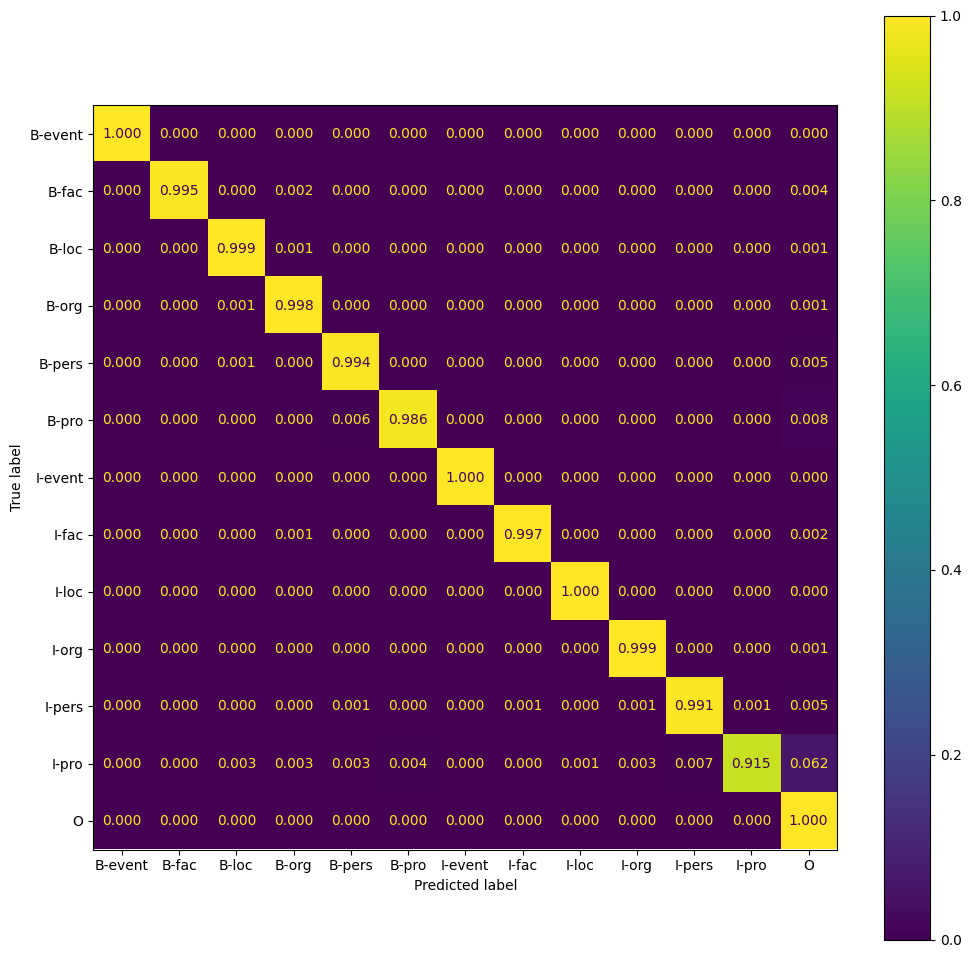

In [92]:
def print_metrics(y_true, y_pred):
  for score in ['Accuracy', 'Precision', 'Recall', 'F1']:
    match score:
      case 'Accuracy':
           s = accuracy_score(y_true, y_pred)
           print(score + ':', '{0:.4f}'.format(s))
      case 'Precision':
           s = precision_score(y_true, y_pred, average='macro', zero_division=1.0)
           s_ = precision_score(y_true, y_pred, average='micro', zero_division=1.0)
           print(score + ' macro:', '{0:.4f}'.format(s))
           print(score + ' micro:', '{0:.4f}'.format(s_))
      case 'Recall':
           s = recall_score(y_true, y_pred, average='macro', zero_division=1.0)
           s_ = recall_score(y_true, y_pred, average='micro', zero_division=1.0)
           print(score + ' macro:', '{0:.4f}'.format(s))
           print(score + ' micro:', '{0:.4f}'.format(s_))
      case 'F1':
           s = f1_score(y_true, y_pred, average='macro', zero_division=1.0)
           s_ = f1_score(y_true, y_pred, average='micro', zero_division=1.0)
           print(score + ' macro:', '{0:.4f}'.format(s))
           print(score + ' micro:', '{0:.4f}'.format(s_))

  fig, ax = plt.subplots(figsize=(12,12))
  disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true', values_format = '.3f', ax=ax)

print_metrics(y_true, y_pred)

## News NER Prediction

Using our model to predict NER tags on another dataset (*distribution shift*), to see how much generalizability our model has.

In [1]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/CurrentData'
!kaggle datasets download -d amirpourmand/tasnimdataset

file_path = '/content/tasnimdataset.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

    news_df = pd.read_csv('/content/tasnim.csv')

 86% 73.0M/84.7M [00:00<00:00, 121MB/s]
100% 84.7M/84.7M [00:00<00:00, 110MB/s]


Prompt used to generated tags from chatGPT. Also all tags are checked manually.

```
NER tag sentences below and return tags in a list of lists for each token and it's tag in a tuple in python
allowable tokens are : ["B-event", "B-fac", "B-loc", "B-org", "B-pers", "B-pro", "I-event", "I-fac", "I-loc", "I-org", "I-pers", "I-pro", "O"]

sentences are presented in list of strings between single quotation and separated by commas.
```



In [41]:
tagged_sentences = [
    [('کشور', 'O'), ('آمریکا', 'B-loc'), ('با', 'O'), ('بیشترین', 'O'), ('تعداد', 'O'), ('مبتلایان', 'O'), ('در', 'O'), ('جهان', 'O'), ('با', 'O'), ('افزایش', 'O'), ('۳۶', 'O'), ('هزار', 'O'), ('و', 'O'), ('۸۹۶', 'O'), ('مبتلا', 'O'), ('در', 'O'), ('۲۴', 'O'), ('ساعت', 'O'), ('گذشته', 'O'), ('،', 'O'), ('به', 'O'), ('مجموع', 'O'), ('۳۰', 'O'), ('میلیون', 'O'), ('و', 'O'), ('۸۱', 'O'), ('هزار', 'O'), ('و', 'O'), ('۶۵۷', 'O'), ('نفر', 'O'), ('رسیده', 'O'), ('است', 'O'), ('؛', 'O'), ('تاکنون', 'O'), ('۵۴۷', 'O'), ('هزار', 'O'), ('و', 'O'), ('۲۳۴', 'O'), ('آمریکایی', 'O'), ('مبتلا', 'O'), ('به', 'O'), ('کووید', 'O'), ('۱۹', 'O'), ('در', 'O'), ('این', 'O'), ('کشور', 'O'), ('جان', 'O'), ('خود', 'O'), ('را', 'O'), ('از', 'O'), ('دست', 'O'), ('داده‌اند', 'O')],
    [('از', 'O'), ('خداوند', 'B-pers'), ('متعال', 'O'), ('،', 'O'), ('سلامتی', 'O'), ('و', 'O'), ('موفقیت', 'O'), ('آن', 'O'), ('جناب', 'O'), ('و', 'O'), ('بهروزی', 'O'), ('مردم', 'O'), ('کویت', 'B-loc'), ('را', 'O'), ('مسألت', 'O'), ('دارم', 'O')],
    [('عین‌اللهی', 'B-pers'), ('خاطر', 'O'), ('نشان', 'O'), ('کرد', 'O'), (':', 'O'), ('با', 'O'), ('توجه', 'O'), ('به', 'O'), ('بهبود', 'O'), ('شرایط', 'O'), ('کرونایی', 'O'), ('برنامه', 'O'), ('داریم', 'O'), ('حضور', 'O'), ('تماشاگران', 'B-pers'), ('در', 'O'), ('ورزشگاه', 'B-loc'), ('تسهیل', 'O'), ('شود', 'O'), ('،', 'O'), ('در', 'O'), ('دیدار', 'O'), ('تیم', 'B-org'), ('ملی', 'I-org'), ('فوتبال', 'I-org'), ('ایران', 'I-org'), ('با', 'O'), ('لبنان', 'B-loc'), ('اجازه', 'O'), ('حضور', 'O'), ('۵۰', 'O'), ('درصدی', 'O'), ('تماشاگران', 'B-pers'), ('صادر', 'O'), ('شده', 'O'), ('و', 'O'), ('اگر', 'O'), ('شیوه', 'O'), ('نامه‌های', 'O'), ('بهداشتی', 'O'), ('به', 'O'), ('خوبی', 'O'), ('رعایت', 'O'), ('شود', 'O'), ('این', 'O'), ('رویه', 'O'), ('ادامه', 'O'), ('پیدا', 'O'), ('خواهد', 'O'), ('کرد', 'O')],
    [('۴', 'O'), ('میلیون', 'O'), ('شهروند', 'B-pers'), ('اتحادیه', 'B-org'), ('اروپا', 'I-org'), ('در', 'O'), ('انگلیس', 'B-loc'), ('با', 'O'), ('توجه', 'O'), ('به', 'O'), ('قواعد', 'O'), ('رایج', 'O'), ('،', 'O'), ('حقوق', 'O'), ('تضمین‌شده', 'O'), ('خود', 'O'), ('در', 'O'), ('توافق', 'O'), ('برگزیت', 'O'), ('را', 'O'), ('از', 'O'), ('دست', 'O'), ('می‌دهند', 'O')],
    [('پایگاه', 'B-org'), ('خبری', 'I-org'), ('«', 'O'), ('aa', 'B-org'), ('»', 'O'), ('دراین‌باره', 'O'), ('نوشت', 'O'), (':', 'O'), ('"', 'O'), ('اگرچه', 'O'), ('مقامات', 'O'), ('فرانسه', 'B-loc'), ('به', 'O'), ('همه', 'O'), ('دانشجویان', 'B-pers'), ('قول', 'O'), ('داده‌اند', 'O'), ('که', 'O'), ('فقط', 'O'), ('با', 'O'), ('۱', 'O')],
    [('قهرمان', 'B-pers'), ('سابق', 'I-pers'), ('کشتی', 'I-pers'), ('آزاد', 'I-pers'), ('جهان', 'I-pers'), ('تاکید', 'O'), ('کرد', 'O'), (':', 'O'), ('همیشه', 'O'), ('در', 'O'), ('کشتی', 'O'), ('بوده', 'O'), ('و', 'O'), ('هستم', 'O'), ('،', 'O'), ('آدمی', 'O'), ('نبودم', 'O'), ('که', 'O'), ('در', 'O'), ('هیچ', 'O'), ('مقطعی', 'O'), ('کشتی', 'O'), ('را', 'O'), ('رها', 'O'), ('کنم', 'O'), ('،', 'O'), ('خیلی', 'O'), ('از', 'O'), ('عزیزان', 'O'), ('اینطوری', 'O'), ('نبودند', 'O'), ('،', 'O'), ('کشتی', 'O'), ('برای', 'O'), ('برخی', 'O'), ('سکوی', 'O'), ('پرتاب', 'O'), ('بوده', 'O'), ('،', 'O'), ('اما', 'O'), ('برای', 'O'), ('من', 'O'), ('هیچ', 'O'), ('وقت', 'O'), ('اینطور', 'O'), ('نبوده', 'O'), ('است', 'O')],
    [('وی', 'O'), ('ادامه', 'O'), ('داد', 'O'), (':', 'O'), ('این', 'O'), ('رویداد', 'O'), ('برای', 'O'), ('رای', 'O'), ('اولی', 'O'), ('هم', 'O'), ('،', 'O'), ('بسیار', 'O'), ('مهم', 'O'), ('است', 'O'), ('و', 'O'), ('جشن', 'O'), ('ملی', 'O'), ('محسوب', 'O'), ('می‌شود', 'O')],
    [('آزمون', 'B-pers'), ('بازیکن', 'O'), ('جالبی', 'O'), ('است', 'O'), ('که', 'O'), ('سال‌هاست', 'O'), ('در', 'O'), ('سطح', 'O'), ('خوبی', 'O'), ('بازی', 'O'), ('کرده', 'O'), ('با', 'O'), ('این', 'O'), ('وجود', 'O'), ('او', 'O'), ('هرگز', 'O'), ('در', 'O'), ('یک', 'O'), ('تیم', 'O'), ('بزرگ', 'O'), ('و', 'O'), ('لیگ', 'O'), ('رقابتی', 'O'), ('به', 'O'), ('میدان', 'B-loc'), ('نرفته', 'O'), ('است', 'O')],
    [('آیتم‌هایی', 'O'), ('داشتیم', 'O'), ('درباره', 'O'), ('شناخت', 'O'), ('همسران', 'O'), ('نسبت', 'O'), ('به', 'O'), ('دیگر', 'O'), ('؛', 'O'), ('برای', 'O'), ('انتقال', 'O'), ('بهتر', 'O'), ('مفاهیم', 'O'), ('آن', 'O'), ('از', 'O'), ('عناصری', 'O'), ('مثل', 'O'), ('توپ', 'O'), ('شلیک', 'O'), ('کردن', 'O'), ('برای', 'O'), ('این', 'O'), ('شناخت', 'O'), ('استفاده', 'O'), ('کردیم', 'O')],
    [('مدیرکل', 'B-pers'), ('غله', 'I-pers'), ('و', 'I-pers'), ('خدمات', 'I-pers'), ('بازرگانی', 'I-pers'), ('استان', 'B-loc'), ('تهران', 'I-loc'), ('به', 'O'), ('قرار', 'O'), ('داد', 'O'), ('ذخیره‌سازی', 'O'), ('گندم', 'O'), ('با', 'O'), ('بخش', 'O'), ('خصوصی', 'O'), ('اشاره', 'O'), ('کرد', 'O'), ('و', 'O'), ('گفت', 'O'), (':', 'O'), ('امسال', 'O'), ('با', 'O'), ('۷', 'O'), ('مرکز', 'O'), ('با', 'O'), ('ظرفیت', 'O'), ('۳۹۰', 'O'), ('هزار', 'O'), ('تن', 'O'), ('و', 'O'), ('۱۶', 'O'), ('کارخانه', 'O'), ('به', 'O'), ('ظرفیت', 'O'), ('۱۶۲', 'O'), ('هزار', 'O'), ('تن', 'O'), ('قرارداد', 'O'), ('منعقد', 'O'), ('شده', 'O'), ('است', 'O')],
    [('براساس', 'O'), ('آمار', 'O'), ('رسمی', 'O'), ('که', 'O'), ('حوزه', 'O'), ('هنری', 'O'), ('استان', 'B-loc'), ('فارس', 'I-loc'), ('اعلام', 'O'), ('کرده', 'O'), ('هفت', 'O'), ('سینما', 'B-loc'), ('در', 'O'), ('شیراز', 'B-loc'), ('وجود', 'O'), ('دارد', 'O'), ('که', 'O'), ('در', 'O'), ('حال', 'O'), ('حاضر', 'O'), ('فقط', 'O'), ('سه', 'O'), ('سالن', 'B-loc'), ('سینما', 'I-loc'), ('از', 'O'), ('سالن‌های', 'O'), ('حوزه', 'O'), ('هنری', 'O'), ('در', 'O'), ('شیراز', 'B-loc'), ('فعال', 'O'), ('است', 'O'), ('و', 'O'), ('۴', 'O'), ('سالن', 'B-loc'), ('مورد', 'O'), ('کم', 'O'), ('توجهی', 'O'), ('قرار', 'O'), ('گرفته', 'O'), ('و', 'O'), ('غیرفعال', 'O'), ('است', 'O')],
    [('وی', 'O'), ('درخصوص', 'O'), ('ایمنی', 'O'), ('و', 'O'), ('پدافند', 'O'), ('شیمیایی', 'O'), ('باتوجه', 'O'), ('به', 'O'), ('توسعه', 'O'), ('صنعت', 'O'), ('نفت', 'O'), ('و', 'O'), ('گاز', 'O'), ('خاطرنشان', 'O'), ('کرد', 'O'), (':', 'O'), ('لازم', 'O'), ('است', 'O'), ('زیرساخت‌ها', 'O'), ('و', 'O'), ('نظامات', 'O'), ('ایمنی', 'O'), ('ایجاد', 'O'), ('شود', 'O'), ('تا', 'O'), ('خطرات', 'O'), ('در', 'O'), ('این', 'O'), ('حوزه', 'O'), ('متوجه', 'O'), ('مردم', 'O'), ('نشود', 'O'), ('که', 'O'), ('الحمدلله', 'O'), ('تاکنون', 'O'), ('اقدامات', 'O'), ('خوبی', 'O'), ('انجام‌گرفته', 'O'), ('است', 'O')],
    [('از', 'O'), ('بازیکنانم', 'O'), ('بابت', 'O'), ('اراده', 'O'), ('خوبی', 'O'), ('که', 'O'), ('برای', 'O'), ('پیروزی', 'O'), ('در', 'O'), ('این', 'O'), ('بازی', 'O'), ('نشان', 'O'), ('دادند', 'O'), ('،', 'O'), ('تشکر', 'O'), ('می‌کنم', 'O')],
    [('اهمیت', 'O'), ('حدیث', 'O'), ('در', 'O'), ('میان', 'O'), ('مسلمانان', 'B-pers'), ('از', 'O'), ('آن', 'O'), ('روست', 'O'), ('که', 'O'), ('از', 'O'), ('منابع', 'O'), ('اصلی', 'O'), ('استنباط', 'O'), ('احکام', 'O'), ('در', 'O'), ('فقه', 'O'), ('و', 'O'), ('عقاید', 'O'), ('در', 'O'), ('علم', 'O'), ('کلام', 'O'), ('محسوب', 'O'), ('می‌شود', 'O')],
    [('البته', 'O'), ('ما', 'O'), ('به', 'O'), ('همه', 'O'), ('بازیکنان', 'O'), ('واکسیناسیون', 'O'), ('کرونا', 'O'), ('را', 'O'), ('توصیه', 'O'), ('می‌کنیم', 'O'), ('و', 'O'), ('این', 'O'), ('برای', 'O'), ('ورزش', 'O'), ('تنیس', 'O'), ('در', 'O'), ('مقابله', 'O'), ('با', 'O'), ('این', 'O'), ('بیماری', 'O'), ('ضروری', 'O'), ('است', 'O')]
]

tagged_sentences_2 = [
    [('رئیس‌جمهور', 'B-pers'), ('با', 'O'), ('تأکید', 'O'), ('بر', 'O'), ('لزوم', 'O'), ('ایجاد', 'O'), ('ثبات', 'O'), ('در', 'O'), ('بازار', 'B-loc'), ('و', 'O'), ('انجام', 'O'), ('اقدامات', 'O'), ('پیشگیرانه', 'O'), ('از', 'O'), ('نوسانات', 'O'), ('ارزی', 'O'), ('،', 'O'), ('بانک', 'B-org'), ('مرکزی', 'I-org'), ('را', 'O'), ('موظف', 'O'), ('کرد', 'O'), ('با', 'O'), ('فعال', 'O'), ('کردن', 'O'), ('ساز', 'O'), ('و', 'O'), ('کارهای', 'O'), ('بانکی', 'O'), ('و', 'O'), ('اقتصادی', 'O'), ('ارزهای', 'O'), ('موجود', 'O'), ('در', 'O'), ('خارج', 'O'), ('از', 'O'), ('کشور', 'O'), ('را', 'O'), ('به', 'O'), ('داخل', 'O'), ('بازگرداند', 'O')],
    [('بر', 'O'), ('همین', 'O'), ('اساس', 'O'), ('می‌توان', 'O'), ('گفت', 'O'), ('صنعت', 'O'), ('گردشگری', 'O'), ('به', 'O'), ('مثابه', 'O'), ('لوکوموتیوی', 'O'), ('است', 'O'), ('که', 'O'), ('دیگر', 'O'), ('اجزا', 'O'), ('و', 'O'), ('ارگان‌های', 'O'), ('اقتصادی', 'O'), ('را', 'O'), ('می‌تواند', 'O'), ('به', 'O'), ('دنبال', 'O'), ('خود', 'O'), ('به', 'O'), ('راه', 'O'), ('بیندازد', 'O')],
    [('این', 'O'), ('کارشناس', 'B-pers'), ('لبنانی', 'I-pers'), ('ادامه', 'O'), ('داد', 'O'), ('،', 'O'), ('اکنون', 'O'), ('«', 'O'), ('طارق', 'B-pers'), ('البیطار', 'I-pers'), ('»', 'O'), ('قاضی', 'O'), ('فعلی', 'O'), ('پرونده', 'O'), ('انفجار', 'O'), ('بیروت', 'B-loc'), ('نیز', 'O'), ('گزارش', 'O'), ('فنی', 'O'), ('انفجار', 'O'), ('را', 'O'), ('بنا', 'O'), ('به', 'O'), ('دلایل', 'O'), ('سیاسی', 'O'), ('کاملا', 'O'), ('مخفی', 'O'), ('کرده', 'O'), ('و', 'O'), ('در', 'O'), ('تلاش', 'O'), ('برای', 'O'), ('متهم', 'O'), ('کردن', 'O'), ('تیم', 'O'), ('رئیس‌جمهور', 'B-pers'), ('و', 'O'), ('حزب‌الله', 'B-org'), ('در', 'O'), ('این', 'O'), ('انفجار', 'O'), ('است', 'O')],
    [('تاکنون', 'O'), ('۳۶', 'O'), ('میلیون', 'O'), ('و', 'O'), ('۵۷', 'O'), ('هزار', 'O'), ('و', 'O'), ('۳۱۵', 'O'), ('آزمایش', 'O'), ('تشخیص', 'O'), ('کووید', 'O'), ('۱۹', 'O'), ('در', 'O'), ('کشور', 'O'), ('انجام‌شده', 'O'), ('است', 'O')],
    [('ان‌شاءالله', 'O'), ('در', 'O'), ('این', 'O'), ('بازی', 'O'), ('،', 'O'), ('تمام', 'O'), ('بازیکنان', 'B-pers'), ('صحیح', 'O'), ('و', 'O'), ('سالم', 'O'), ('از', 'O'), ('زمین', 'O'), ('خارج', 'O'), ('شوند', 'O')],
    [('جوکار', 'B-pers'), ('عنوان', 'O'), ('کرد', 'O'), (':', 'O'), ('در', 'O'), ('این', 'O'), ('صورت', 'O'), ('استانداران', 'B-pers'), ('می‌توانند', 'O'), ('با', 'O'), ('بر', 'O'), ('اساس', 'O'), ('منابع', 'O'), ('انسانی', 'O'), ('و', 'O'), ('طبیعی', 'O'), ('موجود', 'O'), ('در', 'O'), ('استان', 'B-loc'), ('،', 'O'), ('برنامه‌ریزی', 'O'), ('و', 'O'), ('بهترین', 'O'), ('فرصت‌ها', 'O'), ('را', 'O'), ('برای', 'O'), ('توسعه', 'O'), ('ایجاد', 'O'), ('کنند', 'O'), ('که', 'O'), ('لازمه', 'O'), ('آن', 'O'), ('افزایش', 'O'), ('اختیارات', 'O'), ('استانداران', 'B-pers'), ('است', 'O')],
    [('به', 'O'), ('گزارش', 'O'), ('خبرنگار', 'B-pers'), ('اقتصادی', 'I-pers'), ('،', 'O'), ('بر', 'O'), ('اساس', 'O'), ('اعلام', 'O'), ('سازمان', 'O'), ('راهداری', 'B-org'), ('در', 'O'), ('محور', 'O'), ('چالوس', 'B-loc'), ('مسیر', 'O'), ('جنوب', 'B-loc'), ('به', 'O'), ('شمال', 'B-loc'), ('حدفاصل', 'O'), ('بیلقان', 'B-loc'), ('تا', 'O'), ('سرودار', 'B-loc'), ('و', 'O'), ('مسیر', 'O'), ('(', 'O'), ('شمال', 'B-loc'), ('به', 'O'), ('جنوب', 'B-loc'), (')', 'O'), ('حدفاصل', 'O'), ('مرزن‌آباد', 'B-loc'), ('تا', 'O'), ('میانک', 'B-loc'), ('و', 'O'), ('محدوده‌های', 'O'), ('انارک', 'B-loc'), ('،', 'O'), ('هریجان', 'B-loc'), ('،', 'O'), ('تونل', 'B-loc'), ('کندوان', 'I-loc'), ('و', 'O'), ('وینه', 'B-loc'), ('،', 'O'), ('در', 'O'), ('محور', 'B-loc'), ('هراز', 'I-loc'), ('مسیر', 'O'), ('(', 'O'), ('شمال', 'B-loc'), ('به', 'O'), ('جنوب', 'B-loc'), (')', 'O'), ('محدوده‌های', 'O'), ('تونل', 'O'), ('شماره', 'O'), ('یک', 'O'), ('،', 'O'), ('بایجان', 'B-loc'), ('،', 'O'), ('آب', 'B-loc'), ('اسک', 'I-loc'), ('و', 'O'), ('مبارک', 'B-loc'), ('آباد', 'I-loc'), ('و', 'O'), ('در', 'O'), ('آزادراه', 'O'), ('پردیس', 'B-loc'), ('–', 'O'), ('تهران', 'B-loc'), ('محدوده', 'O'), ('جاجرود', 'B-loc'), ('ترافیک', 'O'), ('سنگین', 'O'), ('است', 'O')],
    [('هایاشی', 'B-pers'), ('یوشیماسا', 'I-pers'), ('بر', 'O'), ('اهمیت', 'O'), ('تشکیل', 'O'), ('دولت', 'O'), ('فراگیر', 'O'), ('در', 'O'), ('افغانستان', 'B-loc'), ('و', 'O'), ('احترام', 'O'), ('به', 'O'), ('حقوق', 'O'), ('زنان', 'O'), ('و', 'O'), ('اقلیت‌های', 'O'), ('قومی', 'O'), ('و', 'O'), ('نابودی', 'O'), ('تروریسم', 'O'), ('در', 'O'), ('این', 'O'), ('کشور', 'O'), ('تاکید', 'O'), ('کرد', 'O')],
    [('به', 'O'), ('گزارش', 'O'), ('از', 'O'), ('بیروت', 'B-loc'), ('،', 'O'), ('بحران‌های', 'O'), ('روزافزون', 'O'), ('در', 'O'), ('لبنان', 'B-loc'), ('این', 'O'), ('بانوی', 'B-pers'), ('لبنانی', 'I-pers'), ('را', 'O'), ('مجبور', 'O'), ('کرد', 'O'), ('به', 'O'), ('نظافت', 'O'), ('منازل', 'B-loc'), ('بپردازد', 'O'), ('و', 'O'), ('بتواند', 'O'), ('از', 'O'), ('این', 'O'), ('طریق', 'O'), ('،', 'O'), ('هزینه‌های', 'O'), ('شیرخشک', 'O'), ('فرزندانش', 'O'), ('را', 'O'), ('فراهم', 'O'), ('کند', 'O')],
    [('به', 'O'), ('گزارش', 'O'), ('خبرنگار', 'B-pers'), ('فرهنگی', 'I-pers'), ('،', 'O'), ('یکی', 'O'), ('از', 'O'), ('معضلات', 'O'), ('جدی', 'O'), ('در', 'O'), ('رسانه', 'B-org'), ('ملی', 'I-org'), ('که', 'O'), ('ایام', 'O'), ('نوروز', 'O'), ('هم', 'O'), ('مخاطب', 'O'), ('را', 'O'), ('آزار', 'O'), ('داد', 'O'), (',', 'O'), ('بی‌نظمی', 'O'), ('در', 'O'), ('پخش', 'O'), ('سریال', 'O'), ('بود', 'O'), ('،', 'O'), ('این', 'O'), ('بار', 'O'), ('از', 'O'), ('همان', 'O'), ('روز', 'O'), ('نخست', 'O'), ('به', 'O'), ('آنتن', 'O'), ('می‌رسد', 'O'), ('و', 'O'), ('«', 'O'), ('رعد', 'O'), ('و', 'O'), ('برق', 'O'), ('»', 'O'), ('شبکه', 'O'), ('پنج', 'O'), ('هم', 'O'), ('به‌علت', 'O'), ('مشکلات', 'O'), ('فنی', 'O'), ('با', 'O'), ('یک', 'O')],
    [('رئیس', 'B-pers'), ('اتاق', 'I-pers'), ('بازرگانی', 'I-pers'), ('بوشهر', 'B-loc'), ('نیز', 'O'), ('توسعه', 'O'), ('صادرات', 'O'), ('را', 'O'), ('یکی', 'O'), ('از', 'O'), ('هدف‌گذاری‌های', 'O'), ('دولت', 'O'), ('دانست', 'O'), ('و', 'O'), ('اظهار', 'O'), ('داشت', 'O'), (':', 'O'), ('یکی', 'O'), ('از', 'O'), ('اهداف', 'O'), ('مهم', 'O'), ('این', 'O'), ('دولت', 'O'), ('توجه', 'O'), ('به', 'O'), ('صادرات', 'O'), ('و', 'O'), ('حمایت', 'O'), ('از', 'O'), ('تولیدکنندگان', 'O'), ('و', 'O'), ('صادرکنندگان', 'O'), ('است', 'O')],
    [('به', 'O'), ('عنوان', 'O'), ('مثال', 'O'), ('پس', 'O'), ('از', 'O'), ('حادثه', 'O'), ('دلخراش', 'O'), ('زلزله', 'O'), ('در', 'O'), ('سرپل', 'B-loc'), ('ذهاب', 'I-loc'), ('،', 'O'), ('سقوط', 'O'), ('هواپیمای', 'O'), ('مسافربری', 'O'), ('تهران', 'O'), ('و', 'O'), ('تیپ‌های', 'O'), ('واکنش', 'O'), ('سریع', 'O'), ('نیروی', 'B-org'), ('زمینی', 'I-org'), ('ارتش', 'I-org'), ('در', 'O'), ('محل', 'O'), ('حادثه', 'O'), ('بودند', 'O'), ('،', 'O'), ('البته', 'O'), ('اینها', 'O'), ('در', 'O'), ('قالب', 'O')],
    [('آیت‌الله', 'B-pers'), ('رئیسی', 'I-pers'), ('همچنین', 'O'), ('با', 'O'), ('اعلام', 'O'), ('حمایت', 'O'), ('جمهوری', 'B-loc'), ('اسلامی', 'I-loc'), ('ایران', 'I-loc'), ('از', 'O'), ('تشکیل', 'O'), ('دولت', 'O'), ('قوی', 'O'), ('در', 'O'), ('لبنان', 'B-loc'), ('گفت', 'O'), (':', 'O'), ('ما', 'O'), ('از', 'O'), ('هرگونه', 'O'), ('کمک', 'O'), ('انسان‌دوستانه', 'O'), ('به', 'O'), ('مردم', 'O'), ('لبنان', 'B-loc'), ('دریغ', 'O'), ('نخواهیم', 'O'), ('کرد', 'O'), ('و', 'O'), ('آماده', 'O')],
    [('وی', 'O'), ('خاطرنشان', 'O'), ('کرد', 'O'), (':', 'O'), ('تاکنون', 'O'), ('تأمین', 'O'), ('زمین', 'O'), ('در', 'O'), ('۱۶', 'O'), ('شهر', 'O'), ('برای', 'O'), ('اجرای', 'O'), ('طرح', 'O'), ('جهش', 'O'), ('مسکن', 'O'), ('انجام‌شده', 'O'), ('و', 'O'), ('پس', 'O'), ('از', 'O'), ('پالایش', 'O'), ('متقاضیان', 'O'), ('و', 'O'), ('تشکیل', 'O'), ('پرونده‌ها', 'O'), ('،', 'O'), ('اقدامات', 'O'), ('اجرایی', 'O'), ('لازم', 'O'), ('نیز', 'O'), ('عملیاتی', 'O'), ('خواهد', 'O'), ('شد', 'O')],
    [('این', 'B-pers'), ('کارشناس', 'I-pers'), ('اقتصادی', 'I-pers'), ('درخصوص', 'O'), ('جلسه', 'O'), ('اقتصاددانان', 'O'), ('با', 'O'), ('رئیس‌جمهور', 'B-pers'), ('گفت', 'O'), (':', 'O'), ('جلسه', 'O'), ('شامگاه', 'O'), ('سه‌شنبه', 'O'), ('با', 'O'), ('آقای', 'B-pers'), ('رئیس‌جمهور', 'I-pers'), ('خوب', 'O'), ('مدیریت', 'O'), ('نشد', 'O'), ('و', 'O'), ('به‌جای', 'O'), ('اینکه', 'O'), ('در', 'O'), ('مسائل', 'O'), ('کلان‌تر', 'O'), ('و', 'O'), ('معیشت', 'O'), ('مردم', 'O'), ('بحث', 'O'), ('شود', 'O'), ('اکثر', 'O')],
    [('وی', 'O'), ('افزود', 'O'), (':', 'O'), ('ما', 'O'), ('در', 'O'), ('فدراسیون', 'B-org'), ('در', 'O'), ('این', 'O'), ('موضوع', 'O'), ('دخالتی', 'O'), ('نداریم', 'O'), ('و', 'O'), ('معاونت', 'B-pers'), ('قهرمانی', 'I-pers'), ('و', 'O'), ('همچنین', 'O'), ('معاونت', 'B-pers'), ('حقوقی', 'I-pers'), ('وزارت', 'B-org'), ('ورزش', 'I-org'), ('باید', 'O'), ('در', 'O'), ('این', 'O'), ('باره', 'O'), ('اظهار', 'O'), ('نظر', 'O'), ('لازم', 'O'), ('را', 'O'), ('انجام', 'O'), ('دهند', 'O')],
]
tagged_sentences += tagged_sentences_2

In [93]:
data = {'sentence': [], 'tag': []}
for row in tagged_sentences:
  row = np.asarray(row)
  data['sentence'].append(list(row[:,0]))
  data['tag'].append(list(row[:,1]))
pred, _ = model(data['sentence'])

Accuracy: 0.8828
Precision macro: 0.4730
Precision micro: 0.8828
Recall macro: 0.3995
Recall micro: 0.8828
F1 macro: 0.2692
F1 micro: 0.8828


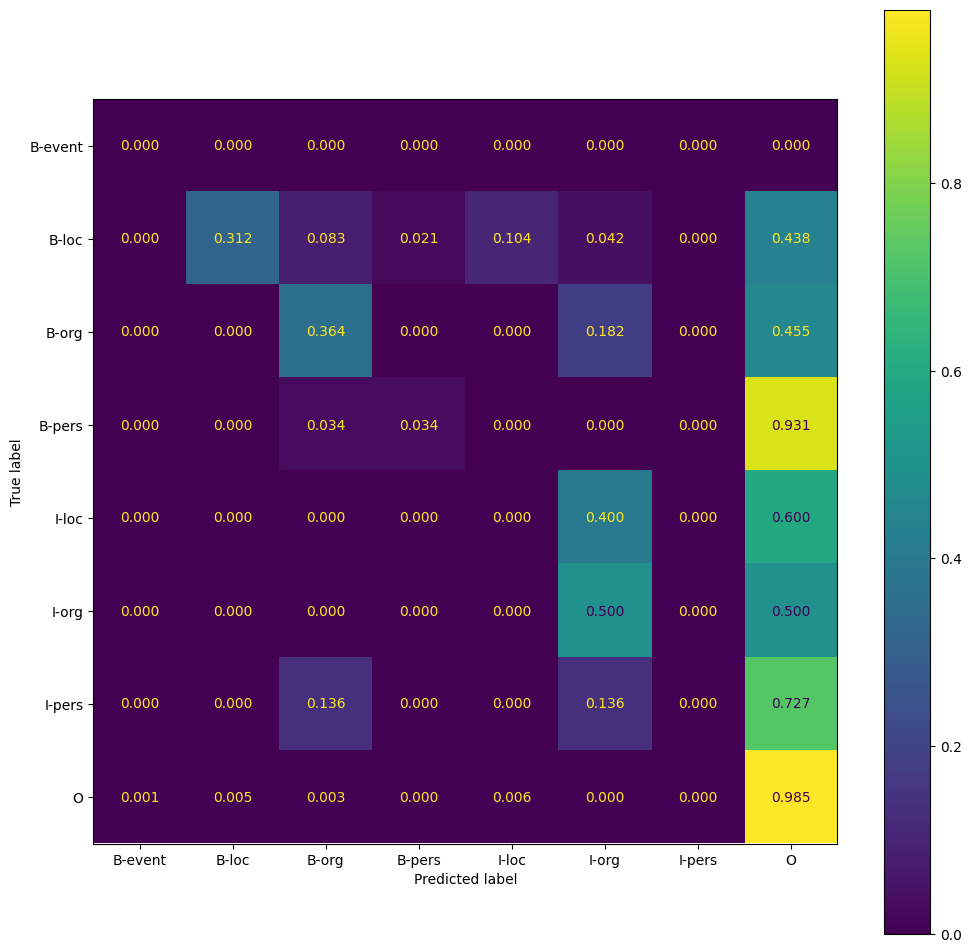

In [95]:
y_true = []
y_pred = []
for tgs in data['tag']:
  for t in tgs:
    y_true.append(t)
for tgs in pred:
  for t in tgs:
    y_pred.append(t)

print_metrics(y_true, y_pred)

# Transformer

In this section we will do the same task, but this time we will use Transformers. We will not train any model here, only using Huggingface models and **fine-tuning** them.

## Dictionary for Conversion between Tag and ID

Creating dictionary of tag to id and id to tag. This is used to convert tag strings to numbers.

In [99]:
with open('/content/corpus/tags.json') as f:
  unique_tags = json.load(f)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

## Encoding Input

Here we're using `ParsBERT` tokenizer from Huggingface to tokenize our sentences. Also we need to set `return_offsets_mapping=True` to get tokens start and end indecies.

In [100]:
checkpoint = "HooshvareLab/bert-base-parsbert-armanner-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

train_encodings = tokenizer(train_data['sentence'], is_split_into_words=True, return_offsets_mapping=True, padding=True)
val_encodings = tokenizer(val_data['sentence'], is_split_into_words=True, return_offsets_mapping=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/937 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Matching new Tokens and Labels

Tokenizers typically utilize subtokens to tokenize sentences and words. To ensure compatibility between these new tokens and our original dataset (tags), we will use token offsets. In a simple approach, we can consider each token as starting from index `0` and ending at an index other than `0`. However, we may still encounter some mismatches. To address this issue, we will add extra `'O'` tags to match the size of our labels.

In [ ]:
def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset), dtype=int) * -100
        arr_offset = np.array(doc_offset)
        diff = len(arr_offset[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)]) - len(doc_labels)
        doc_labels += [7] * diff
        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

train_labels = encode_tags(train_data['tag'], train_encodings)
val_labels = encode_tags(val_data['tag'], val_encodings)

## Creating Torch Dataset (Train, Validation)

In [ ]:
class ARMANDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings.pop("offset_mapping") # we don't want to pass this to the model
val_encodings.pop("offset_mapping")

train_dataset = ARMANDataset(train_encodings, train_labels)
val_dataset = ARMANDataset(val_encodings, val_labels)

## Training Model using Trainer

Here, we use Huggingface `Trainer` to fine-tune our model. Due to the limited resources of the Colab GPU, we fine-tuned the model for only 10 epochs (approximately 30 minutes). Additionally, to accommodate limited memory, we chose for a batch size of 256 (which is achieved through 16 batch sizes multiplied by 16 accumulation steps).

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(checkpoint)
model.resize_token_embeddings(len(tokenizer))
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    gradient_accumulation_steps=16,
    fp16=True
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()
trainer.save_model("/content/drive/MyDrive/CurrentData/fine_tuned_model")

pytorch_model.bin:   0%|          | 0.00/651M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-armanner-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss


Step,Training Loss


## Evaluation on Test Dataset

Here we used ParsBERT documentation code (modified) to predict NER tags for our test dataset sentences.

### Predicting Labels

In [102]:
def cleanize(text):
    """A way to normalize and even clean the text"""
    return normalizer.normalize(text)

def parsbert_ner_load_model(model_name):
    """Load the model"""
    try:
        config = AutoConfig.from_pretrained(model_name)
        model = TFAutoModelForTokenClassification.from_pretrained(model_name)
        labels = list(config.label2id.keys())
        return model, labels
    except:
        return [None] * 2


def parsbert_ner(texts, tokenizer, model_name="/content/drive/MyDrive/CurrentData/fine_tuned_model"):
    model, labels = parsbert_ner_load_model(model_name)
    model.resize_token_embeddings(len(tokenizer))

    if not model or not tokenizer or not labels:
        return 'Something wrong has been happened!'

    output_predictions = []
    for sequence in texts:
        sequence = cleanize(sequence)
        tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
        inputs = tokenizer.encode(sequence, return_tensors="tf")
        outputs = model(inputs)[0]
        predictions = tf.argmax(outputs, axis=2)
        predictions = [(token, labels[prediction]) for token, prediction in zip(tokens, predictions[0].numpy())]

        output_predictions.append(predictions)
    return output_predictions

In [ ]:
texts = [' '.join(sl) for sl in test_data['sentence']]

predictions = parsbert_ner(texts, tokenizer)

All PyTorch model weights were used when initializing TFBertForTokenClassification.

All the weights of TFBertForTokenClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


In [ ]:
# with open('/content/drive/MyDrive/CurrentData/ner_tagged_3.pkl', "wb") as f:
#   pickle.dump(predictions, f)

# with open('/content/drive/MyDrive/CurrentData/ner_tagged.pkl', "rb") as f:
#   predictions = pickle.load(f)

### Matching new Tokens and Labels

To address the mismatch between true label tokens and tokenizer tokens, we attempted another approach. Here we:


1.   We create a dictionary mapping tokens to tags.
2.   For each predicted NER tag, we search for its corresponding token in our dictionary.
3.   If a token is missing, we break it down into its meaningful subtokens and attempt to find them.
4.    Additionally, there are further details regarding this approach

In [ ]:
test_data_kv_dict = []
for i, sent in enumerate(test_data['sentence']):
  curr_dict = {'0':[]}
  for j, token in enumerate(sent):
    if token == 'ـ':
      continue
    if token == '0':
      curr_dict[token] += [test_data['tag'][i][j]]
      continue

    token = tokenizer.tokenize(normalizer.normalize(token))
    for t in token:
      if t in curr_dict:
        curr_dict[t] += [test_data['tag'][i][j]]
      else:
        curr_dict[t] = [test_data['tag'][i][j]]
  test_data_kv_dict.append(curr_dict)

In [ ]:
temp = copy.deepcopy(test_data_kv_dict)
y_true = []
y_pred = []
for i, pred in enumerate(predictions):
  has_error = False
  for j, (token, ner_tag) in enumerate(pred):
    if token == '[CLS]' or token == '[SEP]' or token == '[UNK]':
      continue
    if token == '۰':
      token = '0'
    try:
      if token not in temp[i]:
        for k in range(1,len(token)):
          first = token[:k]
          second = token[k:]
          if (first in temp[i] and second in temp[i]):
            token = first
            break
          if (second in temp[i] and first == '##'):
            token = second
            break
        if token not in temp[i]:
          for k in range(1,len(token)):
            first = token[:k]
            if first in temp[i]:
              token = first
              break

      label = temp[i][token].pop(0)
    except Exception as error:
      if type(error).__name__ == 'IndexError':
        for k in range(1,len(token)):
          first = token[:k]
          second = token[k:]
          if (first in temp[i] and second in temp[i]):
            token = first
            break
          if (second in temp[i] and first == '##'):
            token = second
            break
        try:
          label = temp[i][token].pop(0)
        except Exception as e:
          label = None
      else:
        label = None
    if label:
      y_true.append(label)
      y_pred.append(ner_tag)

### Calculating Metrics

Accuracy: 0.9965
Precision macro: 0.9664
Precision micro: 0.9965
Recall macro: 0.9728
Recall micro: 0.9965
F1 macro: 0.9683
F1 micro: 0.9965


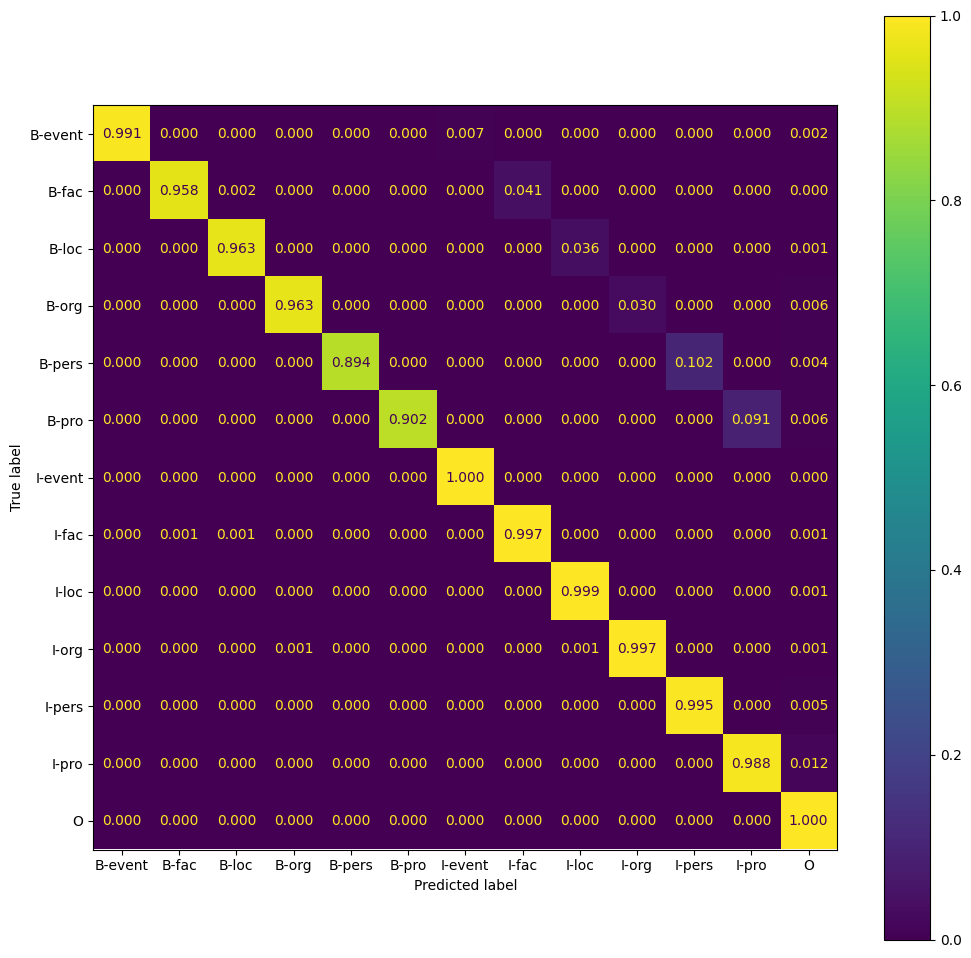

In [ ]:
print_metrics(y_true, y_pred)

### Evaluation on News Dataset

In [96]:
data = {'sentence': [], 'tag': []}
for row in tagged_sentences:
  row = np.asarray(row)
  data['sentence'].append(' '.join(list(row[:,0])))
  data['tag'].append(list(row[:,1]))

predictions = parsbert_ner(data['sentence'], tokenizer)

In [116]:
data_kv_dict = []
for i, sent in enumerate(data['sentence']):
  curr_dict = {'0':[]}
  for j, token in enumerate(sent.split()):
    if token == 'ـ':
      continue
    if token == '0':
      curr_dict[token] += [data['tag'][i][j]]
      continue

    token = tokenizer.tokenize(normalizer.normalize(token))
    for t in token:
      if t in curr_dict:
        curr_dict[t] += [data['tag'][i][j]]
      else:
        curr_dict[t] = [data['tag'][i][j]]
  data_kv_dict.append(curr_dict)

y_true = []
y_pred = []

for i, pred in enumerate(predictions):
  has_error = False
  for j, (token, ner_tag) in enumerate(pred):
    if token == '[CLS]' or token == '[SEP]' or token == '[UNK]':
      continue
    if token == '۰':
      token = '0'
    try:
      if token not in data_kv_dict[i]:
        for k in range(1,len(token)):
          first = token[:k]
          second = token[k:]
          if (first in data_kv_dict[i] and second in data_kv_dict[i]):
            token = first
            break
          if (second in data_kv_dict[i] and first == '##'):
            token = second
            break
        if token not in data_kv_dict[i]:
          for k in range(1,len(token)):
            first = token[:k]
            if first in data_kv_dict[i]:
              token = first
              break

      label = data_kv_dict[i][token].pop(0)
    except Exception as error:
      if type(error).__name__ == 'IndexError':
        for k in range(1,len(token)):
          first = token[:k]
          second = token[k:]
          if (first in data_kv_dict[i] and second in data_kv_dict[i]):
            token = first
            break
          if (second in data_kv_dict[i] and first == '##'):
            token = second
            break
        try:
          label = data_kv_dict[i][token].pop(0)
        except Exception as e:
          label = None
      else:
        label = None
    if label:
      y_true.append(label)
      y_pred.append(ner_tag)

Accuracy: 0.9033
Precision macro: 0.3852
Precision micro: 0.9033
Recall macro: 0.7203
Recall micro: 0.9033
F1 macro: 0.2933
F1 micro: 0.9033


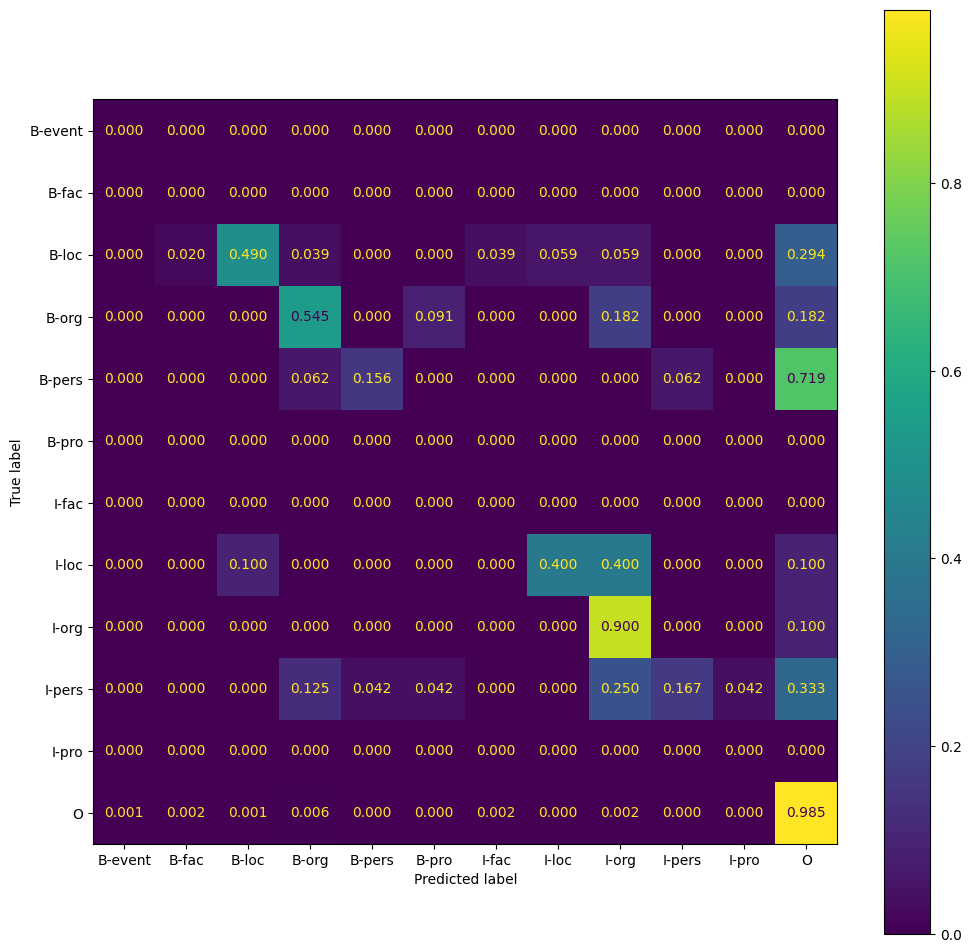

In [119]:
print_metrics(y_true, y_pred)

We can conclude that, although Transformers exhibited lower accuracy on our test dataset compared to LSTM/CRF, it demonstrates good generalization and yields better results on datasets from different distributions.